# Jordan Holbrook
## Macro II
## PS 8
## 4/9/2021

# Equity Premium Puzzle

In [3]:
# Importing Packages
import os
import pandas as pd 
import isbnlib 
import numpy as np
import time
import requests
from bs4 import BeautifulSoup
import datetime
import re
from sympy import symbols, Eq, solve

Reading in the Data

In [6]:
data = pd.read_excel(r"C:\Users\jcholbro\OneDrive - University Of Houston\School_UH\Macro II\Macro_PS8_Data.xlsx", ignore_index=True)

data = data.drop(columns='Unnamed: 2')
data.head(12)

,year,qtr,Consumption,Equity,Bonds
0,1947,1,NaN,NaN,NaN
1,1947,2,0.010879,-0.050602,-0.008857
2,1947,3,-0.002750,0.046852,-0.019506
3,1947,4,-0.011554,-0.023406,-0.022647
4,1948,1,0.005972,-0.052005,-0.007556
5,1948,2,0.009992,0.115816,-0.007229
6,1948,3,-0.001184,-0.000729,-0.005773
7,1948,4,0.009247,-0.013445,0.005318
8,1949,1,0.003337,-0.010638,0.011746
9,1949,2,0.002030,-0.007460,0.009992


### Computing Moments from the Data

In [18]:
mu = np.mean(data.Consumption)
delta = np.std(data.Consumption)
ave_stocks = np.mean(data.Equity)
ave_bonds = np.mean(data.Bonds)
true_premium = ave_stocks-ave_bonds

lambda1 = 1+mu+delta
lambda2 = 1+mu-delta

data['lag_consumption'] = data['Consumption'].shift(1)

cov = data[['Consumption','lag_consumption']].cov()
cov = cov.iloc[0,1]
var = data['Consumption'].var()

rho=(cov+var)/(2*var)
phi=(1+rho)/2

print('mu:  '+ str(mu))
print('delta:  '+ str(delta))
print('rho:  '+ str(rho))
print('phi:  '+ str(phi))

mu:  0.0045141897637948755
delta:  0.005570715863764123
rho:  0.6067036487176168
phi:  0.8033518243588085


In [26]:
phi1 = 1-phi
phi2 = phi

beta = 0.99
sigma = 10

#x, y = symbols('x y')
w1, w2 = symbols('w1 w2')
eq1 = beta*(phi1*w1*lambda1**(1-sigma)+phi2*w2*lambda2**(1-sigma))+beta*(phi1*lambda1**(1-sigma)+phi2*lambda2**(1-sigma))-w1
eq2 = beta*(phi2*w1*lambda1**(1-sigma)+phi1*w2*lambda2**(1-sigma))+beta*(phi2*lambda1**(1-sigma)+phi1*lambda2**(1-sigma))-w2
solve((eq1,eq2), (w1, w2))
solution = solve((eq1,eq2), (w1, w2))

s1=solution[w1]
s2=solution[w2]
returns_stocks = ((lambda1*(s1+1))/s1 + (lambda2*(s2+1))/s2)*(.5)
returns_bonds = 1/(beta*(phi1*lambda1**(-sigma)+(phi2*lambda2**(-sigma))))


## 1 a & b) Computing the Returns to Equity and Bonds

In [28]:
print('return equity:  '+ str((returns_stocks-1)*100)+'%')
print('return bonds:  '+ str((returns_bonds-1)*100)+'%')

return equity:  5.61507754019193%
return bonds:  2.054896369982151%


### 1 c) Is the unconditional equity premium close to that in the data?

In [29]:
premium  = (returns_stocks-1)-(returns_bonds-1)
print(premium*100)
how_close = true_premium-premium
print(true_premium)
print(how_close)


3.56018117020978
0.01651910470348718
-0.0190827069986106


#### The Equity Premium is about 1% off from the true premium in the data. This could be due to misspecifying the parameters incorrectly in the model or not calibrating the model to the data moments correctly. We do however, have the correct implication from the model. The Return to Equity is higher than that of the return to bonds.

## 2) Habit Presistence


#### Here we specify the range of parameter values that we want to search through.

In [31]:
sigma_list = list(range(1,11))
beta_list = list(np.linspace(0.90,1.0,11))
delta_list = list(np.linspace(0.25,1.25,11))
results_rows = []
w1, w2 = symbols('w1 w2')


In [32]:
# Giant triple for loop to grid search through our parameter values
for beta in beta_list:
    for sigma in sigma_list:
        for delta in delta_list:
            results_col= {}

            #print(delta)
            #print(sigma)
            #print(beta)
            
            M1 = ((lambda1-delta)/(1-(delta/lambda1)))**(-sigma)
            M2 = ((lambda2-delta)/(1-(delta/lambda2)))**(-sigma)
            
            eq3 = beta*(phi1*w1*lambda1*M1+phi2*w2*lambda2*M2)+beta*(phi1*lambda1*M1+phi2*lambda2*M2)-w1      
            eq4 = beta*(phi2*w1*lambda1*M1+phi1*w2*lambda2*M2)+beta*(phi2*lambda1*M1+phi1*lambda2*M2)-w2
            solve((eq3,eq4), (w1, w2))
            solution2 = solve((eq3,eq4), (w1, w2))
            s1=solution2[w1]
            s2=solution2[w2]
            
            returns_stocks = ((lambda1*(s1+1))/s1 + (lambda2*(s2+1))/s2)*(.5)
            
            returns_bonds = 1/(beta*(phi1*lambda1**(-sigma)+(phi2*lambda2**(-sigma))))
            
            premium  = returns_stocks-returns_bonds
            #print(premium)
            how_close = true_premium-premium
            
            results_col['model premium'] = premium*100
            results_col['data_premium'] = true_premium*100
            results_col['difference'] = how_close
            results_col['parameters'] = [beta,sigma, delta]
            results_rows.append(results_col)
            

TypeError: list indices must be integers or slices, not Symbol

In [33]:
table = pd.DataFrame(results_rows)   
table.head(25)

,model premium,data_premium,difference,parameters
0,0.377692228627069,1.65191,0.0127421824172165,"[0.9, 1, 0.25]"
1,0.377692228627069,1.65191,0.0127421824172165,"[0.9, 1, 0.35]"
2,0.377692228627069,1.65191,0.0127421824172165,"[0.9, 1, 0.45]"
3,0.377692228627069,1.65191,0.0127421824172165,"[0.9, 1, 0.55]"
4,0.377692228627069,1.65191,0.0127421824172165,"[0.9, 1, 0.65]"
5,0.377692228627069,1.65191,0.0127421824172165,"[0.9, 1, 0.75]"
6,0.377692228627136,1.65191,0.0127421824172158,"[0.9, 1, 0.8500000000000001]"
7,0.377692228627069,1.65191,0.0127421824172165,"[0.9, 1, 0.9500000000000001]"
8,0.377692228627247,1.65191,0.0127421824172147,"[0.9, 1, 1.05]"
9,0.377692228627136,1.65191,0.0127421824172158,"[0.9, 1, 1.15]"


In [45]:
table['abs_difference'] = abs(table['difference'])

In [46]:
    
table['abs_difference'] = table['abs_difference'].astype(float)
table['abs_difference'].idxmin()
table.loc[table['abs_difference'].idxmin()]




model premium     1.74283745873896
data_premium               1.65191
difference             -0.00090927
parameters         [0.99, 5, 0.35]
abs_difference          0.00090927
Name: 1035, dtype: object

## Best Parameters
### Beta = 0.99
### Sigma = 5
### Delta = 0.35

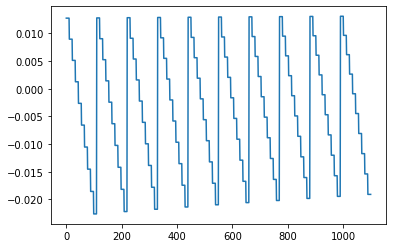

In [40]:
import matplotlib.pyplot as plt
plt.plot(table.difference)

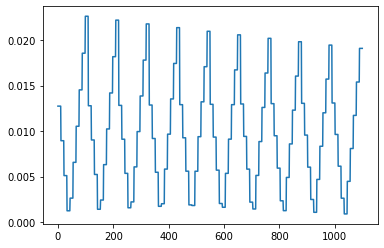

In [47]:
plt.plot(table.abs_difference)